# Capstone Project: Slogan Classifier and Generator

In this capstone project you will train a Long Short-Term Memory (LSTM) model to generate slogans for businesses based on their industry, and also train a classifier to predict the industry based on a given slogan.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Libraries
We recommend running this notebook using [Google Colab](https://colab.google/) however if you choose to use your local machine you will need to install spaCy before starting.

To install spaCy, refer to the installation instructions provided on the spaCy [website](https://spacy.io/usage). Note you may need to install an older version of Python that is compatible with spaCy. You can create a virtual environment for this project to install the specific version of Python that you need.

spaCy tutorials used: https://spacy.io/usage/spacy-101, https://realpython.com/natural-language-processing-spacy-python/, https://medium.com/@kpradyumna/end-to-end-spacy-tutorial-826a3caadd9c

In [2]:
import pandas as pd
import numpy as np
import random

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, \
    Dense
from tensorflow.keras.optimizers import Adam

import spacy # available on Google Colab

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

import matplotlib.pyplot as plt
import seaborn as sns

## Loading and viewing the dataset

- Load the slogan dataset into a variable called data.
- Extract relevant columns in a variable called df.
- Handle missing values.

Do **not** change the column names.

If you are using Google Colab you will need mount your Google Drive as follows:  
`from google.colab import drive`  
`drive.mount('/content/drive')`  

The path you use when loading your data will look something like this if you are using your Google Drive:  
"/content/drive/MyDrive/Colab Notebooks/slogan-valid.csv"

In [3]:
# Load data from your local machine or from your Google Drive
# Name your pandas DataFrame 'df'
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/slogan-valid.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5346 entries, 0 to 5345
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   desc           5346 non-null   object
 1   output         5346 non-null   object
 2   type           5346 non-null   object
 3   company        5346 non-null   object
 4   industry       5346 non-null   object
 5   url            5346 non-null   object
 6   alias          4017 non-null   object
 7   desc_masked    5346 non-null   object
 8   output_masked  5346 non-null   object
 9   ent_dict       5346 non-null   object
 10  unsupported    5346 non-null   bool  
 11  first_pos      5346 non-null   object
dtypes: bool(1), object(11)
memory usage: 464.8+ KB


In [5]:
# View sample data
df.sample(10)

,desc,output,type,company,industry,url,alias,desc_masked,output_masked,ent_dict,unsupported,first_pos
2813,<company> is the cash flow performance platfor...,"AR Automation, Collections Management, and Cas...",headline_long,tesorio,financial services,tesorio.com,Tesorio,<company> is the cash flow performance platfor...,"AR Automation, Collections Management, and Cas...",{},False,NN
653,PPS is the nation's leading provider of creden...,Nationwide Credentialing Services & Practice S...,headline_long,physician practice specialists,hospital & health care,physicianpracticespecialists.com,NaN,PPS is the nation's leading provider of creden...,Nationwide Credentialing Services & Practice S...,{'[number]': '1000'},False,NN
4689,The Peak Performance Project - Where Science M...,Where Science Meets Athletic Performance,headline,p3 applied sports science,sports,p3.md,P3,The Peak Performance Project - Where Science M...,Where Science Meets Athletic Performance,{},False,OTHER
992,Run a VIN Check for an exclusive vehicle histo...,Vehicle History Report,headline,"vinaudit.com, inc.",automotive,vinaudit.com,Vinaudit.Com,Run a VIN Check for an exclusive vehicle histo...,Vehicle History Report,{'[date]': 'today'},False,NN
2152,Our digital dictation equipment keeps your pro...,Digital Dictation Made Easier and Faster,headline_long,copia business machines,business supplies and equipment,copia.com.au,Copia,Our digital dictation equipment keeps your pro...,Digital Dictation Made Easier and Faster,{},False,NN
4331,<company> is specialized in the manufacturing ...,the knowledge of all prototyping processes,headline_long,ec international group,mechanical or industrial engineering,ec-international-group.com,Ec International Group,<company> is specialized in the manufacturing ...,the knowledge of all prototyping processes,{},False,DT
2749,<company> Email Marketing Services. All-in-one...,Email Marketing & Marketing Automation Platform,headline_long,sales-push.com,marketing and advertising,sales-push.com,NaN,<company> Email Marketing Services. All-in-one...,Email Marketing & Marketing Automation Platform,{},False,NN
5031,Ocean inspired swim & activewear empowering yo...,Eco-responsible apparel advocating for marine ...,headline_long,waterlust,media production,waterlust.org,Waterlust,[location] inspired swim & activewear empoweri...,Eco-responsible apparel advocating for marine ...,{'[location]': 'Ocean'},False,NN
2631,Proudly appointing electricians in Michigan ov...,Your Local Electricians,headline,"united electrical contractors, inc.",construction,unitedelectric-inc.com,"United Electrical Contractors, Inc",Proudly appointing electricians in [country] o...,Your Local Electricians,"{'[country]': 'Michigan', '[date]': '20 years'...",False,PR
4365,Structural engineers specialize in parking gar...,"Structural Engineers, Parking Garage Restorati...",headline_long,innovative engineering inc. structural enginee...,civil engineering,ieiusa.com,NaN,Structural engineers specialize in parking gar...,"Structural Engineers, Parking Garage Restorati...",{},False,NN


User Requirement Specification (URS):


1.   generate business slogans from the industry
2.   predict/infer the industry from a slogan

To train the model, I need a list of slogans with corresponding industry. The only columns needed are output (slogans) and industry.



In [6]:
# Remove all columns except output and industry
col_ls = (
    'desc', 'type', 'company', 'url', 'alias',
    'desc_masked', 'output_masked', 'ent_dict', 'unsupported', 'first_pos'
)
df.drop(list(col_ls), axis=1, inplace=True)
df.head()

,output,industry
0,Taking Care of Small Business Technology,computer hardware
1,Build World-Class Recreation Programs,"health, wellness and fitness"
2,Most Powerful Lead Generation Software for Mar...,internet
3,Hire quality freelancers for your job,internet
4,"Financial Advisers Norwich, Norfolk",financial services


Data cleansing: check for duplicate rows, missing values, and industry classification errors.

In [7]:
# Check for duplicate rows and remove them
shape_start = df.shape
print(f"Initial shape: {shape_start}")
df.drop_duplicates(inplace=True)
shape_end = df.shape
print(f"Shape after removing duplicates: {shape_end}")
print(f"Number of duplicate rows removed: {shape_start[0] - shape_end[0]}")

Initial shape: (5346, 2)
Shape after removing duplicates: (5326, 2)
Number of duplicate rows removed: 20


In [8]:
# Get the number of missing data values per column
missing_values = df.isnull().sum()
display(missing_values)

,0
output,0
industry,0


No missing values.

In [9]:
df.describe()

,output,industry
count,5326,5326
unique,5313,142
top,Full Service Marketing Agency,information technology and services
freq,2,446


In [10]:
# Review the 142 industry entries to check for typos and misnamings
sorted = df.sort_values('industry')
print(sorted['industry'].unique())

['accounting' 'airlines/aviation' 'alternative medicine' 'animation'
 'apparel & fashion' 'architecture & planning' 'arts and crafts'
 'automotive' 'aviation & aerospace' 'banking' 'biotechnology'
 'broadcast media' 'building materials' 'business supplies and equipment'
 'capital markets' 'chemicals' 'civic & social organization'
 'civil engineering' 'commercial real estate'
 'computer & network security' 'computer games' 'computer hardware'
 'computer networking' 'computer software' 'construction'
 'consumer electronics' 'consumer goods' 'consumer services' 'cosmetics'
 'dairy' 'defense & space' 'design' 'e-learning' 'education management'
 'electrical/electronic manufacturing' 'entertainment'
 'environmental services' 'events services' 'executive office'
 'facilities services' 'farming' 'financial services' 'fine art'
 'food & beverages' 'food production' 'fund-raising' 'furniture'
 'gambling & casinos' 'glass, ceramics & concrete'
 'government administration' 'government relations' 

The industry classifications are correct. There aren't any typos or variations. There are discrepancies around and/& which I may need to come back to.

## Data Preprocessing

Since we are working with textual data, we need software that understands natural language. For this, we'll use a library for processing text called **spaCy**. Using spaCy, we'll break the text into smaller units called tokens that are easier for the machine to process. This process is called **tokenisation**. We'll also convert all text to lowercase and remove punctuation because this information is not necessary for our models. Run the code below, and your dataframe (df) will gain a new column called **'processed_slogan'** which contains the preprocessed text.




In [11]:
# Load spaCy model for text processing
nlp = spacy.load("en_core_web_sm")

# Define text preprocessing function
def preprocess_text(text):
    '''
    Function to preprocess text data
    Parameters:
        text = the text to be processed, string
    Output:
        processed_tokens = the processed text, joined as a string with spaces
    '''
    text_lower = text.lower()
    doc = nlp(text_lower)

    processed_tokens = []

    for token in doc:
        if not token.is_punct:
            processed_tokens.append(token.text)

    return " ".join(processed_tokens)

df["processed_slogan"] = df["output"].apply(preprocess_text)

df.head()

,output,industry,processed_slogan
0,Taking Care of Small Business Technology,computer hardware,taking care of small business technology
1,Build World-Class Recreation Programs,"health, wellness and fitness",build world class recreation programs
2,Most Powerful Lead Generation Software for Mar...,internet,most powerful lead generation software for mar...
3,Hire quality freelancers for your job,internet,hire quality freelancers for your job
4,"Financial Advisers Norwich, Norfolk",financial services,financial advisers norwich norfolk


We want our model to generate **industry-specific** slogans. If we use the 'processed_slogan' column as it is, we'll be leaving out crucial context - the industries of the companies behind those slogans. To fix this, we'll create a new **'modified_slogan'** column that adds the industry name to the front of processed slogan.  

For example:  

> industry = 'computer hardware'  
processed_slogan = 'taking care of small business technology'  
modified_slogan = 'computer hardware taking care of small business technology'

Write code in the cell below to achieve this.

I added a token to indicate the end of a slogan, `<eos>`, and facilitate early stopping.

In [12]:
df["modified_slogan"] = df["industry"] + " " + df["processed_slogan"] + " <eos>"
df.head()

,output,industry,processed_slogan,modified_slogan
0,Taking Care of Small Business Technology,computer hardware,taking care of small business technology,computer hardware taking care of small busines...
1,Build World-Class Recreation Programs,"health, wellness and fitness",build world class recreation programs,"health, wellness and fitness build world class..."
2,Most Powerful Lead Generation Software for Mar...,internet,most powerful lead generation software for mar...,internet most powerful lead generation softwar...
3,Hire quality freelancers for your job,internet,hire quality freelancers for your job,internet hire quality freelancers for your job...
4,"Financial Advisers Norwich, Norfolk",financial services,financial advisers norwich norfolk,financial services financial advisers norwich ...


Now we need to get data to train our model. We have textual data which we will need to represent numerically for our model to learn from it.  
The code below does the following:
1. Tokenizes a dataset of slogans.
2. Converts words to numerical indices.
3. Creates input sequences using the numerical indices.  

Here's how it works. From the 'modified_slogan' column, we take the slogan "computer hardware taking care of small business technology". The tokenisation process will convert words into their corresponding indices:  

<center>

| Word         | Token Index |
|-------------|-------|
| "computer"  | 1     |
| "hardware"  | 2     |
| "taking"    | 3     |
| "care"      | 4     |
| "of"        | 5     |
| "small"     | 6     |
| "business"  | 7     |
| "technology"| 8     |

</center>

So the tokenized list is:

<center>
[1, 2, 3, 4, 5, 6, 7, 8]
</center>

When creating input sequences for training, the loop generates progressively longer sequences.

<center>

| Token Index Sequence               | Corresponding Slogan                                 |
|------------------------------|-----------------------------------------------------|
| [1, 2]                       | "computer hardware"                                |
| [1, 2, 3]                    | "computer hardware taking"                        |
| [1, 2, 3, 4]                 | "computer hardware taking care"                   |
| [1, 2, 3, 4, 5]              | "computer hardware taking care of"                |
| [1, 2, 3, 4, 5, 6]           | "computer hardware taking care of small"          |
| [1, 2, 3, 4, 5, 6, 7]        | "computer hardware taking care of small business" |
| [1, 2, 3, 4, 5, 6, 7, 8]     | "computer hardware taking care of small business technology" |

</center>

Instead of training the model on only **complete slogans**, we provide partial phrases which will help the model learn how words connect over time. This will make it better at predicting the next word when generating slogans.  

Run the cell block below to generate the input sequences. Be sure to read the comments to understand what the code is doing.


In [13]:
# Tokenizer to convert words into numerical values tokens
tokenizer = Tokenizer()

# Tokenizer learns words in dataset
tokenizer.fit_on_texts(df["modified_slogan"])

# Total number of unique words in learned vocabulary
total_words = len(tokenizer.word_index) + 1

# Dictionary mapping words to its numerical index:
# index based on frequency i.e., more freq => lower index
tokenizer.word_index

# Creating input sequences
# Initialise list to store the input sequences
input_sequences = []

# Iterate over processed slogans
for line in df["modified_slogan"]:

    # Convert slogans to token sequences
    # returns list containing list of words indices; extracting inner list [0]
    token_list = tokenizer.texts_to_sequences([line])[0]

    # token_list is a list of tokenized word indices
    # Building list of progressively longer input sequences for better training
    for i in range(1, len(token_list)):
        input_sequences.append(token_list[:i+1])

The input sequences created above are of **varying lengths**, which will be a problem when training our LSTM model. LSTMs require input sequences of **equal length**. So, we need to **pad** shorter sequences by **prepending zeros** until they match the length of the longest sequence.  

For example, if the longest sequence has **10 tokens**, our padded sequences will look like this:

<center>

| Input Sequence                     | Padded Sequence                         |
|-------------------------------------|-----------------------------------------|
| [1, 2]                              | [0, 0, 0, 0, 0, 0, 0, 0, 1, 2]         |
| [1, 2, 3]                           | [0, 0, 0, 0, 0, 0, 0, 1, 2, 3]         |
| [1, 2, 3, 4]                        | [0, 0, 0, 0, 0, 0, 1, 2, 3, 4]         |
| [1, 2, 3, 4, 5]                     | [0, 0, 0, 0, 0, 1, 2, 3, 4, 5]         |
| [1, 2, 3, 4, 5, 6]                  | [0, 0, 0, 0, 1, 2, 3, 4, 5, 6]         |
| [1, 2, 3, 4, 5, 6, 7]               | [0, 0, 0, 1, 2, 3, 4, 5, 6, 7]         |
| [1, 2, 3, 4, 5, 6, 7, 8]            | [0, 0, 1, 2, 3, 4, 5, 6, 7, 8]         |

</center>

In the cell below, write code that **finds the length of the longest sequence** in **input_sequences** and stores this value in a variable named **max_seq_len**.


In [14]:
max_seq_len = max(len(seq) for seq in input_sequences)
print(f"Length of the longest sequence: {max_seq_len}")

Length of the longest sequence: 16


Run the cell below to pad the input sequences so they are all the same length as **max_seq_length**.

In [15]:
input_sequences = pad_sequences(
    input_sequences, maxlen=max_seq_len, padding="pre"
    )

## Training Data for Slogan Generator

The input sequences generated will be used as our training data. Our LSTM needs to learn how to predict the **next word** in a sequence.  

The inputs for our model will be the input sequences **excluding the last token index** and the outputs will be the **last token index**.  

As an example, let us use the input sequence [0, 0, 1, 2, 3, 4, 5, 6, 7, 8] and say it corresponds to the slogan "computer hardware taking care of small business technology". When training the model:

> Our input **x** will be the input sequence [0, 0, 1, 2, 3, 4, 5, 6, 7] corresponding to "computer hardware taking care of small".  
> Our output **y** will be [8] which corresponds to "business".  

In the code cell below, use `input_sequences` to create the following two variables:
1. **X_gen** which contains the input sequences excluding the last token index.
2. **y_gen** which contains the last token index of the input sequence.

In [16]:
# Use splicing to create X_gen and y_gen
# The last item can be accessed using -1 as the index
# X_gen is the input sequence, except the last item
X_gen = input_sequences[:, :-1]
# y_gen is the last item in the input sequence
y_gen = input_sequences[:, -1]

The model will output the next word of a sequence over a probability distribution. We need to encode our output variable for this to be possible.

In the code cell below, write code that will apply one-hot encoding to **y_gen** using `tf.keras.utils.to_categorical()`. **Maintain the same variable name**.  

*Hint: set the `num_classes` (number of classes) parameter to the total number of unique words in the learned vocabulary. You can access this value through a variable that was created when generating input sequences earlier.*

`tf.keras.utils.to_categorical()` returns a binary matrix of float32 (ie one-hot) based on the number of classes. It is a quick way of one-hot encoding a variable within tensorflow.

References: https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical, https://www.geeksforgeeks.org/machine-learning/python-keras-keras-utils-to_categorical/

In [17]:
y_gen = tf.keras.utils.to_categorical(
    y_gen,
    num_classes=total_words
)

## Slogan Generator Architecture

In the code cell that follows, configure the LSTM following these steps:

1. Create a sequential model using `tf.keras.models.Sequential()`. This model will have an embedding layer, two LSTM layers, and a dense output layer.
2. Add an embedding layer that converts words into dense vector representations. This layer should:
> *   Have `total_words`as the vocabulary size.
> *   Use 100 as an embedding dimension.
> *   Takes an input length of `max_seq_len - 1` (excludes the target word).
3. Add two LSTM layers.
> *   The first LSTM layer should have 150 **and** set `return_sequences` to `True`.
> *   The second LSTM layer should have 100 units.
4. Add a dense output layer which:
> *   Uses `total_words` as the number of units (one for each word in the vocabulary).
> *   Uses a softmax activation function.
5. Use `Sequential` to put everything together in the correct order to complete the architecture of the LSTM model called **gen_model**.


In [18]:
# Model definition using Keras and Sequential()
# Parameters
LSTM_1_size = 150
LSTM_2_size = 100

# Initialise the model
gen_model = Sequential()

# Define the model architecture, excluding the targets ie the last item
# in each sequence so that input_length=max_seq_len-1
gen_model.add(Embedding(
    total_words,
    100
    # input_length=max_seq_len - 1
))
gen_model.add(LSTM(
    LSTM_1_size,
    return_sequences=True
))
gen_model.add(LSTM(
    LSTM_2_size,
    return_sequences=False
))
gen_model.add(Dense(
    total_words,
    activation='softmax'
))

In the code cell below, compile `gen_model` using `categorical_crossentropy` loss, an Adam optimiser, and an appropriate metric of your choice.


In [19]:
# Set learning_rate for Adam
learning_rate = 0.001

In [20]:
# Compile gen_model
gen_model.compile(
    optimizer=Adam(learning_rate=learning_rate),
    loss="categorical_crossentropy",
    metrics=['accuracy']
)

## Slogan Generation

In the code cell below, fit the compiled model on the inputs and outputs, setting the **number of epochs to 50**.

In [21]:
# Set number of epochs
num_epochs = 50

In [22]:
# Fit gen_model
# Consider trialling different batch_sizes eg 16, 64, 128. Smaller batches often
# generalize better, but take longer to train. 32 is a typical starter value.
gen_model.fit(
    X_gen,
    y_gen,
    epochs=num_epochs,
    batch_size=32,
    verbose=1
)

Epoch 1/50
1249/1249 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.1393 - loss: 6.8321
Epoch 2/50
1249/1249 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.2010 - loss: 5.7903
Epoch 3/50
1249/1249 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.2284 - loss: 5.4646
Epoch 4/50
1249/1249 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.2622 - loss: 5.1447
Epoch 5/50
1249/1249 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.2893 - loss: 4.8438
Epoch 6/50
1249/1249 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.3024 - loss: 4.6267
Epoch 7/50
1249/1249 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.3174 - loss: 4.4120
Epoch 8/50
1249/1249 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.3309 - loss: 4.1778
Epoch 9/50
1249/1249 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.3381 - loss: 3.9921
Epoch 10/50
1249/1249 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.3484 - loss: 3.7935
Epoch 11/50
1249/1249 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.3624 - loss: 3.5687
Epoch 12/50
1249/12

We will now define a function called `generate_slogan` which will generate a slogan by predicting one word at a time based on a given starting phrase (the `seed_text`). This function will do this using our trained model, `gen_model`.

Here is a breakdown of how the algorithm works:  

Let us assume the dictionary mapping words to unique indices, `tokenizer.word_index`, looks like this:

> `{'computer': 1, 'hardware': 2, 'taking': 3, 'care': 4, 'of': 5}`

If the model's predicted index for the next word is 3 (`predicted_index = 3`), the loop will:

> Check 'computer' (index 1) → No match  
> Check 'hardware' (index 2) → No match  
> Check 'taking' (index 3) → Match found!  
> Assign output_word = "taking" and exit the loop.  

The `output_word` will be appended to the `seed_text`, and the process will continue to add words to the `seed_text` until we have reached the maximum number of words **or** an invalid prediction occurs.  

Carefully follow the code below and complete the missing parts as guided by the comments.

In [23]:
def generate_slogan(seed_text, max_words=20):
    '''
    Function to generate a slogan word by word until either max_words is
    reached or <eos> is predicted.
    Parameters:
        seed_text = the starting phrase, string
        max_words = the maximum number of words to generate, int
    Output:
        generated_output = the generated slogan, string
    '''
    # List to collect only the words generated by the model
    generated_words = []
    current_seed = seed_text

    for _ in range(max_words):
        # Tokenising and padding current_seed for prediction
        token_list = tokenizer.texts_to_sequences([current_seed])[0]
        token_list = pad_sequences(
            [token_list], maxlen=max_seq_len - 1, padding="pre"
        )

        # Predict the next word
        predictions = gen_model.predict(
            token_list,
            verbose=0
        )
        predicted_index = np.argmax(predictions)

        output_word = None

        # Searching for the word that corresponds to the predicted index
        for word, index in tokenizer.word_index.items():
            if index == predicted_index:
                output_word = word
                break

        if output_word == 'eos':  # early stop if eos token is predicted
            break
        elif output_word is None:
            print("Error: output_word is None.")
            break
        else:
            # Append the generated word to our list
            generated_words.append(output_word)
            # Update current_seed for the next iteration's prediction
            current_seed += " " + output_word

    return " ".join(generated_words)

In [24]:
# Test the function for industries: 'finance', 'health, wellness and fitness'
# and 'construction'
test_1 = generate_slogan("finance")
test_2 = generate_slogan("health, wellness and fitness")
test_3 = generate_slogan("construction")

print(
    f"Sample slogan for finance:\n    {test_1}"
    f"\nSample slogan for health, wellness and fitness:\n    {test_2}"
    f"\nSample slogan for construction:\n    {test_3}"
)

Sample slogan for finance:
    we create healthcare service i cash calling in miami
Sample slogan for health, wellness and fitness:
    the best medical solutions
Sample slogan for construction:
    commercial residential construction brisbane blackwatch


## Training Data for Slogan Classifier

We will now prepare the data we will use to train our classifier. For our classifier, the inputs will come from the `processed_slogans` column of our DataFrame, `df`. The outputs will be the different industry categories under the `industry` column.

In the code cell below, extract the unique values from the `industry` column in the DataFrame and store these in a variable called **industries**.

In [25]:
# During initial data preparation, I prepared a dataframe of the values in the
# industry column, which I called sorted.
industries = sorted['industry'].unique()

Create a dictionary called `industry_to_index` where each unique industry is mapped to a unique index starting from 0.

*Hint: Use the `enumerate()` function.*

In [26]:
industry_to_index = {}
for i, industry in enumerate(industries):
    industry_to_index[industry] = i

# Display the first 10 items
display(list(industry_to_index.items())[:10])

[('accounting', 0),
 ('airlines/aviation', 1),
 ('alternative medicine', 2),
 ('animation', 3),
 ('apparel & fashion', 4),
 ('architecture & planning', 5),
 ('arts and crafts', 6),
 ('automotive', 7),
 ('aviation & aerospace', 8),
 ('banking', 9)]

Create a new column `industry_index` in your DataFrame by mapping the `industry` column to the indices using the `industry_to_index` dictionary.

*Hint: Use the  `map()` function.*

In [27]:
df['industry_index'] = df['industry'].map(industry_to_index)
df.head()

,output,industry,processed_slogan,modified_slogan,industry_index
0,Taking Care of Small Business Technology,computer hardware,taking care of small business technology,computer hardware taking care of small busines...,21
1,Build World-Class Recreation Programs,"health, wellness and fitness",build world class recreation programs,"health, wellness and fitness build world class...",52
2,Most Powerful Lead Generation Software for Mar...,internet,most powerful lead generation software for mar...,internet most powerful lead generation softwar...,65
3,Hire quality freelancers for your job,internet,hire quality freelancers for your job,internet hire quality freelancers for your job...,65
4,"Financial Advisers Norwich, Norfolk",financial services,financial advisers norwich norfolk,financial services financial advisers norwich ...,41


Split the DataFrame `df` into training and testing sets, setting aside 20% of the data for the test set. Be sure to set the parameter `stratify=df["industry_index"]`. This ensures that both sets have the same proportion of each class (industry) as in the original dataset, resulting in balanced datasets. Call the training DataFrame `df_train` and the testing DataFrame `df_test`.

Stratify ensures equal proportions of target variable values in the training and test datasets. This requires at least two examples. If there are industries with only one example, they cannot be stratified. I can remove those examples entirely, or I can handle them separately. I choose the latter so my model is as comprehensive as possible. I will separate any industries with only one example and add them to the training set.

In [28]:
# Identify industries with only one example
industry_counts = df['industry_index'].value_counts()
single_indices = industry_counts[industry_counts < 2].index

# Create DataFrames for single and multi-instance industries
df_single = df[df['industry_index'].isin(single_indices)].copy()
df_multi = df[~df['industry_index'].isin(single_indices)].copy()

# Perform train-test split on the multi-instance DataFrame with stratification
df_multi_train, df_test = train_test_split(
    df_multi, test_size=0.2, random_state=47,
    stratify=df_multi["industry_index"]
)

# Concatenate df_single with df_multi_train
df_train = pd.concat(
    [df_multi_train, df_single], ignore_index=True
)

# Check shapes of df_train and df_test
print(f"Shape of df_train: {df_train.shape}")
print(f"Shape of df_test: {df_test.shape}")

Shape of df_train: (4262, 5)
Shape of df_test: (1064, 5)


Our classifier will use padded slogan sequences as inputs, similar to input sequences used for the slogan generator. The difference is we will not use sequences that get progressively longer, but instead we will use **complete slogans**. This is because our classifier does not need to learn how to predict what word comes next. It needs the full context of a slogan to learn how to accurately predict the industry.  

The next steps will walk you through how to create these sequences.  

We previously created and fitted a `Tokenizer` object called `tokenizer` while preparing data for the slogan generator. Now, we will reuse it to convert words into numerical indices.  

In the code cell below, use the `texts_to_sequences()` **method** of `tokenizer` to transform the `processed_slogan` column in **both** the `df_train` and `df_test` DataFrames into sequences of numerical indices. Store the results in variables named `X_train` and `X_test`.


In [29]:
X_train = tokenizer.texts_to_sequences(df_train['processed_slogan'])
X_test = tokenizer.texts_to_sequences(df_test['processed_slogan'])

The slogan sequences are of varying lengths. We will need to pad them the same way we did to the input sequences for the slogan generator. The `pad_sequences()` function can ensure the sequences in `slogan_sequences` have the same length.  

In the code cell below, use the `pad_sequences()` function to standardise the `slogan_sequences` lengths. Set the `maxlen` parameter to `max_seq_len`, the `padding` parameter to 0, and assign the resulting padded sequences to the same variables, `X_train` and `X_test`.

In [30]:
# The slogan_sequences are stored in X_train and X_test
max_seq_len = max(len(slogan) for slogan in X_train + X_test)
print(f"Length of the longest slogan is: {max_seq_len}")

Length of the longest slogan is: 12


In [31]:
X_train = pad_sequences(
    X_train,
    maxlen=max_seq_len,
    padding="pre"
)
X_test = pad_sequences(
    X_test,
    maxlen=max_seq_len,
    padding="pre"
)

We have successfully created training and testing inputs for our model. Now, we will create the outputs - industry categories.

 In the code cell that follows, use `tf.keras.utils.to_categorical()` to apply one-hot encoding to the `industry_index` column of **both** `df_train` and `df_test` DataFrames. Assign the results to a variables named `y_train` and `y_test`.

 *Hint: set the `num_classes` parameter to the total number of industries in the DataFrame. The `industries` variable can be used to find this value.*

In [32]:
# The classifier target y is the industry_index
y_train = tf.keras.utils.to_categorical(
    df_train['industry_index'],
    num_classes=len(industries)
)
y_test = tf.keras.utils.to_categorical(
    df_test['industry_index'],
    num_classes=len(industries)
)

## Slogan Classifier Architecture

Configure the LSTM classifier following these steps:  


1. Create a Sequential model:  
   Use `tf.keras.models.Sequential()` to create a sequential model. This model will consist of an embedding layer, two LSTM layers, and a dense output layer.

2. Add an embedding layer which will convert words into dense vector representations. Configure this layer with:
   > * `total_words` as the vocabulary size.
   > * 100 as the embedding dimension.
   > * `max_seq_len` as the `input_length` (this is the length of the slogans).

3. Add the first LSTM layer. Configure it with:
   > * 150 units.
   > * Set `return_sequences` to `True` to ensure the layer outputs sequences for the next LSTM layer.

4. Add the second LSTM layer which will process the output from the previous LSTM layer. Configure it with:
   > * 100 units.
   > * No need to set `return_sequences` here (it is the final LSTM layer).

5. Add the dense output layer which will classify the data into industries. Configure it with:
   > * The number of unique industries as the number of units.
   > * The `softmax` activation function to get probabilities for each class (industry).

6. Use `Sequential` to arrange all layers in the correct order and complete the architecture of the LSTM model called **class_model**.


In [33]:
# Model definition using Keras and Sequential()
# Parameters defined previously
# LSTM_1_size = 150
# LSTM_2_size = 100

# Initialise the model
class_model = Sequential()

# Define the model architecture
class_model.add(Embedding(
    total_words,
    100
    # input_length=max_seq_len
))
class_model.add(LSTM(
    LSTM_1_size,
    return_sequences=True
))
class_model.add(LSTM(
    LSTM_2_size,
    return_sequences=False
))
class_model.add(Dense(
    len(industries),
    activation='softmax'
))

In the code cell below, compile `class_model` using `categorical_crossentropy` loss, an Adam optimiser, and an appropriate metric of your choice.

In [34]:
# Compile class_model
# The learning_rate parameter was set above
class_model.compile(
    optimizer=Adam(learning_rate=learning_rate),
    loss="categorical_crossentropy",
    metrics=['accuracy']
)

## Slogan Classification & Evaluation

In the code cell that follows, fit the compiled model on the inputs and outputs, setting **the number of epochs to 50**.

In [35]:
# Fit class_model
# The num_epochs parameter was set above
class_model.fit(
    X_train,
    y_train,
    epochs=num_epochs,
    batch_size=32,
    verbose=1
)

Epoch 1/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.0857 - loss: 4.5590
Epoch 2/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.0859 - loss: 4.2923
Epoch 3/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0784 - loss: 4.3130
Epoch 4/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0956 - loss: 4.0107
Epoch 5/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.2008 - loss: 3.5033
Epoch 6/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3345 - loss: 2.8878
Epoch 7/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4493 - loss: 2.4266
Epoch 8/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5558 - loss: 1.9090
Epoch 9/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6339 - loss: 1.6229
Epoch 10/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7017 - loss: 1.3466
Epoch 11/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7454 - loss: 1.1210
Epoch 12/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/st

Evaluate the model using the testing set. Add a comment on the model's performance.

In [36]:
# Make predictions
predictions = class_model.predict(X_test)

# The predictions are the probabilities for each class, but y_test is one-hot.
# Need to convert both these data so they have the same class indices.

# Get the index of the highest probability for predictions
y_pred_classes = np.argmax(predictions, axis=1)

# Get the index of the '1' in the one-hot encoded y_test
y_test_classes = np.argmax(y_test, axis=1)

# Calculate accuracy from the class indices
accuracy = accuracy_score(y_test_classes, y_pred_classes)

print(f"The accuracy of class_model is:\n    {accuracy:.2f}")

# Generate a Classification Report
print("\nClassification Report:")

# Get the unique labels present in the test set
unique_test_labels = np.unique(y_test_classes)
# Filter target_names to only include those present in the test set
filtered_target_names = industries.astype(str)[unique_test_labels]

print(classification_report(
    y_test_classes, y_pred_classes,
    labels=unique_test_labels,
    target_names=filtered_target_names,
    zero_division=0
))

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
The accuracy of class_model is:
    0.20

Classification Report:
                                      precision    recall  f1-score   support

                          accounting       0.62      0.36      0.45        14
                   airlines/aviation       0.00      0.00      0.00         3
                           animation       0.00      0.00      0.00         1
                   apparel & fashion       0.20      0.08      0.12        12
             architecture & planning       0.17      0.17      0.17         6
                     arts and crafts       0.00      0.00      0.00         1
                          automotive       0.41      0.42      0.41        31
                aviation & aerospace       0.00      0.00      0.00         3
                             banking       0.00      0.00      0.00         3
                       biotechnology       0.00      0.00      0.00         5
                     broadcast media 

UndefinedMetricWarnings are produced by the classification report. This indicates that some of the industries have no predictions.

We will now define a function called `classify_slogan` which takes a slogan as input and predicts the industry it belongs to using the trained model, `class_model`.  

Carefully follow the code below and complete the missing parts (indicated by ellipses) as guided by the comments.

In [37]:
def classify_slogan(slogan, model):
    '''
    Function to classify a slogan into an industry using a specified model.
    Parameters:
        slogan = the slogan to classify, string
        model = the trained classification model
    Output:
        predicted_industry = the predicted industry, string
    '''
    # Use the preprocess_text to clean the input slogan (we defined this
    # function in the preprocessing section)
    slogan = preprocess_text(slogan)

    # Converting the slogan to a sequence of indices
    sequence = tokenizer.texts_to_sequences([slogan])

    # Pad the sequence using the pad_sequences() function
    padded_sequence = pad_sequences(
        sequence, maxlen=max_seq_len, padding="pre"
    )

    # Pass padded_sequence into the specified model to get the predicted
    # probabilities for each indistry
    prediction = model.predict(
        padded_sequence,
        verbose=0
    )

    # Use np.argmax() to get the index of the industry with the highest
    # probability.
    # Note: np.argmax() returns a NumPy array, specifically a one-element array
    # in this context.
    # Extract the single value from this array and assign it to predicted_index.
    predicted_index = np.argmax(prediction)

    # Return the predicted industry
    return industries[predicted_index]

In [38]:
# Test the function with two slogans "We build business leaders" from Management
# Consultancy and "Luxury custom yacht" from Shipbuilding.
print(
    f"Predicted industry for 'We build business leaders':"
    f"\n    {classify_slogan('We build business leaders', class_model)}"
)
print(
    f"Predicted industry for 'Luxury custom yacht':"
    f"\n    {classify_slogan('Luxury custom yacht', class_model)}"
)

Predicted industry for 'We build business leaders':
    management consulting
Predicted industry for 'Luxury custom yacht':
    shipbuilding


## Combining the two models

Run the code cell below to combine the two models: we will first generate a slogan for a company in the "internet" industry, then pass the generated slogan to the slogan classifier to see if it correctly classifies it as internet.

In [39]:
industry = "internet"
generated_slogan = generate_slogan(industry)
predicted_industry = classify_slogan(generated_slogan, class_model)

print(
    f"Generated Slogan: {generated_slogan}"
    f"\nPredicted Industry: {predicted_industry}"
)

Generated Slogan: web design and digital marketing agency
Predicted Industry: online media


The failure isn't surprising, since the classification report shows the accuracy of predicted_industry is only 0.20 overall and the precision for the internet class is only 0.11.

Turn the above code into a function and test some other industries.

In [40]:
def combined_test(industry, max_words=20, model=class_model):
    '''
    Function to generate a slogan from an industry and pass it to the slogan
    classifier to see if it correctly identifies it.
    Parameters:
        industry = the industry to generate the slogan for, string
    Output:
        prints results to the screen
    '''
    generated_slogan = generate_slogan(industry, max_words)
    predicted_industry = classify_slogan(generated_slogan, model)

    print(
        f"\nIndustry: {industry}"
        f"\n    Generated Slogan: {generated_slogan}"
        f"\n    Predicted Industry: {predicted_industry}"
        )

In [41]:
# Test the function
combined_test("internet")


Industry: internet
    Generated Slogan: web design and digital marketing agency
    Predicted Industry: online media


In [42]:
# Consider other industries
sample_industries = ["finance", "health, wellness and fitness", "construction"]
for ind in sample_industries:
    combined_test(ind)


Industry: finance
    Generated Slogan: the world 's most straightforward digital paper
    Predicted Industry: financial services

Industry: health, wellness and fitness
    Generated Slogan: the best online find a brewing cloud
    Predicted Industry: leisure, travel & tourism

Industry: construction
    Generated Slogan: commercial residential construction brisbane
    Predicted Industry: law practice


In [43]:
# Consider a randomly selected industry
random_industry = random.choice(industries)
print(
    f"Testing with a randomly selected industry: {random_industry}"
)
combined_test(random_industry)

Testing with a randomly selected industry: wholesale

Industry: wholesale
    Generated Slogan: the leader in kitchen cabinetry
    Predicted Industry: wholesale


Compare the results and comment on any differences you notice between the generated slogans and the classifier’s predictions in the markdown cell below.


# Evaluation and improvements

The overall length of the predicted slogans is longer than expected and they are incomprehensible. Examine the source data for the number of words in each provided slogan.

In [44]:
# Calculate the number of words in each processed slogan
df['word_count'] = df['processed_slogan'].apply(lambda x: len(x.split(' ')))

# Find the distribution statistics for word_count
print("Distribution statistics for 'word_count':")
print(df['word_count'].describe().round(2))

Distribution statistics for 'word_count':
count    5326.00
mean        5.32
std         1.85
min         2.00
25%         4.00
50%         5.00
75%         7.00
max        11.00
Name: word_count, dtype: float64


The mean number of words in the source slogans is 5.32 and the maximum is 11. Retest, setting max_words=10.

In [45]:
# Consider the same industries but setting max_words=10
sample_industries = ["finance", "health, wellness and fitness", "construction"]
for ind in sample_industries:
    combined_test(ind,max_words=10)


Industry: finance
    Generated Slogan: the world 's most straightforward digital paper
    Predicted Industry: financial services

Industry: health, wellness and fitness
    Generated Slogan: the best online find a brewing cloud
    Predicted Industry: leisure, travel & tourism

Industry: construction
    Generated Slogan: commercial residential construction brisbane
    Predicted Industry: law practice


This simply truncates the slogan. It doesn't help the comprehension of the slogan.

I think the first issue to address is the poor accuracy of the classifier. Granted if the generator produces nonsense, the classifier will struggle, but the classes in the input data are imbalanced, and that hasn't been addressed.

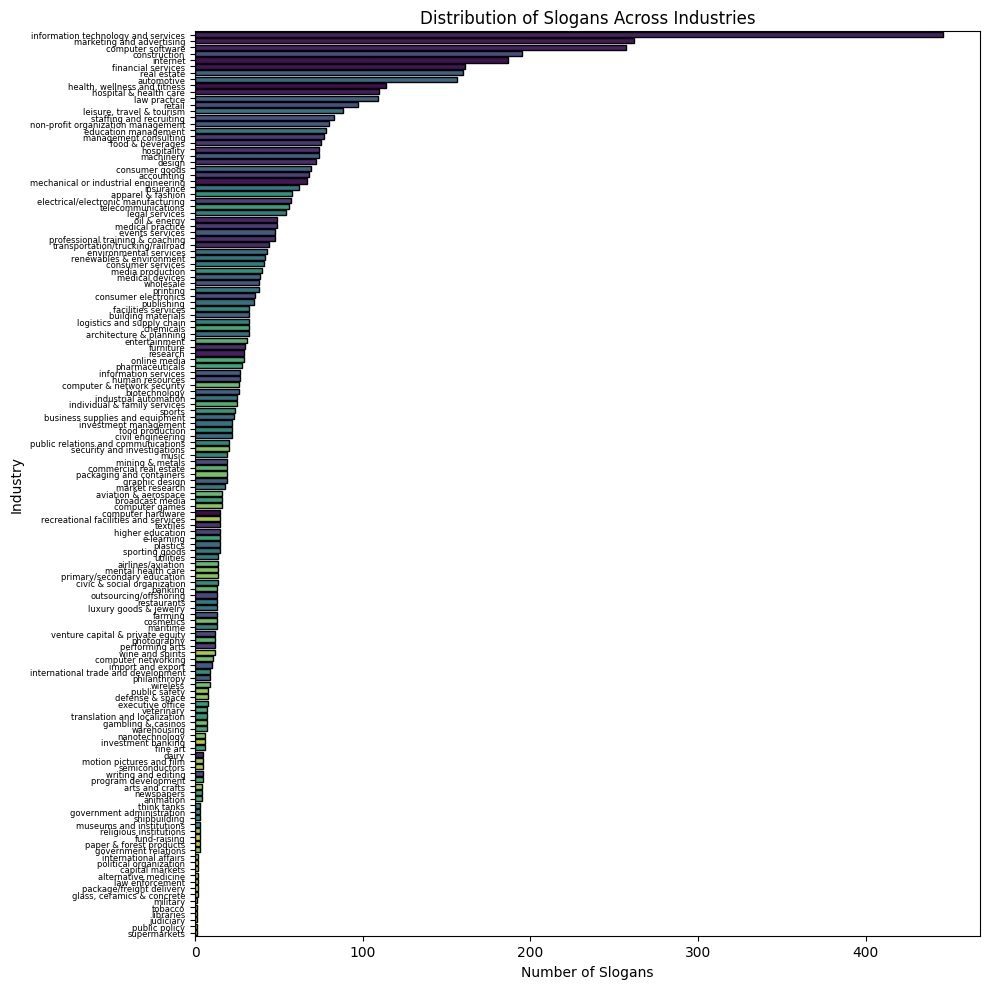

In [46]:
# Show the class distribution in a bar chart
# Prepare data
industry_counts = df['industry'].value_counts()

# Prepare figure
figure = plt.figure(figsize=(10, 10))

# Create bar plot
sns.countplot(
    y='industry',
    data=df,
    order=industry_counts.index,
    palette='viridis',
    hue='industry',
    legend=False,
    edgecolor='black' # Add black outline to bars
)

# Add labels
plt.xlabel('Number of Slogans')
plt.ylabel('Industry')
plt.title('Distribution of Slogans Across Industries')

# Reduce font size of y-axis labels
plt.yticks(fontsize=6)

# Apply log scale to x-axis
# plt.xscale('log')

# Display
plt.tight_layout()
plt.show()

The bar chart above illustrates the large class imbalance in the dataset.

To allow for the class imbalance, I will "normalize" the class distribution. I mean will inverse-scale the weights based on the frequency of the class in the source data. The effect is to equalize the importance assigned to each class during training, and hence avoid biasing the final model towards the over-represented information technology and services class.

After research I found that the correct terminology here is "inverse class frequency weighting".

Ref: https://rtemis.rtemis.org/ImbalancedData.html


In [47]:
# Find the class distribution in the training data
industry_counts = df_train['industry_index'].value_counts()
samples = industry_counts.max()

# Initialise dictionary for class weights
class_weights = {}

# Inverse-scale the weights
for i, count in industry_counts.items():
    class_weights[i] = samples / count

# Display sample results
print("Calculated Class Weights (first 5 items):")
print(list(class_weights.items())[:5])

Calculated Class Weights (first 5 items):
[(61, 1.0), (80, 1.7), (23, 1.733009708737864), (24, 2.2884615384615383), (65, 2.38)]


Build a new model and train it with the class weights defined above.



In [48]:
# Model definition using Keras and Sequential()
# Parameters defined previously
# LSTM_1_size = 150
# LSTM_2_size = 100

# Initialise the new model
class_model_2 = Sequential()

# Define the model architecture (same as class_model)
class_model_2.add(Embedding(
    total_words,
    100
    # input_length=max_seq_len
))
class_model_2.add(LSTM(
    LSTM_1_size,
    return_sequences=True
))
class_model_2.add(LSTM(
    LSTM_2_size,
    return_sequences=False
))
class_model_2.add(Dense(
    len(industries),
    activation='softmax'
))

# Compile class_model_2 (same as class_model)
class_model_2.compile(
    optimizer=Adam(learning_rate=learning_rate),
    loss="categorical_crossentropy",
    metrics=['accuracy']
)

# Fit class_model_2 with class weights
class_model_2.fit(
    X_train,
    y_train,
    epochs=num_epochs,
    batch_size=32,
    verbose=1,
    class_weight=class_weights
)

Epoch 1/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.0033 - loss: 56.9580
Epoch 2/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.0145 - loss: 61.3018
Epoch 3/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0591 - loss: 57.3091
Epoch 4/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.1475 - loss: 49.2369
Epoch 5/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3162 - loss: 37.3627
Epoch 6/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4968 - loss: 24.9118
Epoch 7/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6447 - loss: 15.6019
Epoch 8/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7378 - loss: 10.4943
Epoch 9/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7898 - loss: 6.5514
Epoch 10/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8292 - loss: 4.8895
Epoch 11/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8692 - loss: 3.4006
Epoch 12/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s

Evaluate the performance of class_model_2.



In [49]:
predictions = class_model_2.predict(X_test)
y_pred_classes = np.argmax(predictions, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

accuracy = accuracy_score(y_test_classes, y_pred_classes)

print(f"The accuracy of class_model_2 is:\n    {accuracy:.2f}")

print("\nClassification Report for class_model_2:")
unique_test_labels = np.unique(y_test_classes)
filtered_target_names = industries.astype(str)[unique_test_labels]

print(classification_report(
    y_test_classes, y_pred_classes,
    labels=unique_test_labels,
    target_names=filtered_target_names,
    zero_division=0
))

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
The accuracy of class_model_2 is:
    0.22

Classification Report for class_model_2:
                                      precision    recall  f1-score   support

                          accounting       0.67      0.57      0.62        14
                   airlines/aviation       0.00      0.00      0.00         3
                           animation       0.00      0.00      0.00         1
                   apparel & fashion       0.14      0.08      0.11        12
             architecture & planning       0.29      0.33      0.31         6
                     arts and crafts       0.00      0.00      0.00         1
                          automotive       0.48      0.52      0.50        31
                aviation & aerospace       0.00      0.00      0.00         3
                             banking       0.00      0.00      0.00         3
                       biotechnology       0.00      0.00      0.00         5
                 

Scaling the weights has improved the overall accuracy slightly from 0.20 to 0.21. I hope that working with the data will help more.

First I will return to and vs & in the industry column as noted previously. I will replace & with and to ensure consistency. I think this will help since the model won't understand that and and & are interchangeable.



In [50]:
df['industry'] = df['industry'].str.replace('&', 'and', regex=False)
df.head()

,output,industry,processed_slogan,modified_slogan,industry_index,word_count
0,Taking Care of Small Business Technology,computer hardware,taking care of small business technology,computer hardware taking care of small busines...,21,6
1,Build World-Class Recreation Programs,"health, wellness and fitness",build world class recreation programs,"health, wellness and fitness build world class...",52,5
2,Most Powerful Lead Generation Software for Mar...,internet,most powerful lead generation software for mar...,internet most powerful lead generation softwar...,65,7
3,Hire quality freelancers for your job,internet,hire quality freelancers for your job,internet hire quality freelancers for your job...,65,6
4,"Financial Advisers Norwich, Norfolk",financial services,financial advisers norwich norfolk,financial services financial advisers norwich ...,41,4


I can introduce lemmas into the text_processing. A lemma is the basic form of a group of words for example, surprised and surprising are both grammatical variations on surprise, which is the lemma. Lemmas help text comprehensions to learn relationships between concepts.

I will rework `preprocess_text` to use `token.lemma_` for each token, which extracts the base form of the word. Then, I will re-apply this updated function to the `output` column to update the `processed_slogan` column.



In [51]:
nlp = spacy.load("en_core_web_sm")

def preprocess_text(text):
    '''
    Function to preprocess text data including lemmatization.
    Parameters:
        text = the text to be processed, string
    Output:
        processed_tokens = the processed text, joined as a string with spaces
    '''
    text_lower = text.lower()
    doc = nlp(text_lower)

    processed_tokens = []

    for token in doc:
        if not token.is_punct:
            processed_tokens.append(token.lemma_)

    return " ".join(processed_tokens)

df["processed_slogan"] = df["output"].apply(preprocess_text)
df["modified_slogan"] = df["industry"] + " " + df["processed_slogan"] + " <eos>"
df.head()

,output,industry,processed_slogan,modified_slogan,industry_index,word_count
0,Taking Care of Small Business Technology,computer hardware,take care of small business technology,computer hardware take care of small business ...,21,6
1,Build World-Class Recreation Programs,"health, wellness and fitness",build world class recreation program,"health, wellness and fitness build world class...",52,5
2,Most Powerful Lead Generation Software for Mar...,internet,most powerful lead generation software for mar...,internet most powerful lead generation softwar...,65,7
3,Hire quality freelancers for your job,internet,hire quality freelancer for your job,internet hire quality freelancer for your job ...,65,6
4,"Financial Advisers Norwich, Norfolk",financial services,financial adviser norwich norfolk,financial services financial adviser norwich n...,41,4


The slogan generation method is a simple one: selecting the most probable word based on the previous word. Introducing a probabistic element should improve the generated slogans. This can lead to more diverse outputs, improving the quality of the generated slogans.

I will implement Top-P sampling, which selects from a subset of words that exceed a probability threshold. Writing a new generate_slogan function to use Top-P.

Refs: https://en.wikipedia.org/wiki/Top-p_sampling

https://towardsdatascience.com/guide-to-chatgpts-advanced-settings-top-p-frequency-penalties-temperature-and-more-b70bae848069/

In [52]:
# I had some assistance from gemini to rewrite this function properly.
def generate_slogan_2(seed_text, max_words=20, p=0.9):
    '''
    Function to generate a slogan word by word using Top-P (nucleus) sampling.

    Parameters:
        seed_text = the starting phrase, string
        max_words = the maximum number of words to generate, int
        p = the probability threshold for Top-P sampling, float

    Output:
        generated_output = the generated slogan, string
    '''
    generated_words = []
    current_seed = seed_text

    for _ in range(max_words):
        token_list = tokenizer.texts_to_sequences([current_seed])[0]
        token_list = pad_sequences(
            [token_list], maxlen=max_seq_len - 1, padding="pre"
        )

        # Get predictions for the current token_list
        predictions = gen_model.predict(
            token_list,
            verbose=0
        )[0]

        # Apply Top-P sampling
        # Sort indices by probability in descending order
        sorted_indices = np.argsort(predictions)[::-1]
        sorted_probabilities = predictions[sorted_indices]
        cumulative_probabilities = np.cumsum(sorted_probabilities)

        # Select indices where cumulative probability is less than p
        # Add extra token to include the first token that crosses the threshold
        nucleus_indices = sorted_indices[cumulative_probabilities < p]
        if len(nucleus_indices) == 0:
            # Fallback if no words meet the criteria, take the top word
            predicted_index = sorted_indices[0]
        else:
            # Also include the first word that crosses the threshold 'p'
            if len(cumulative_probabilities) > len(nucleus_indices):
                nucleus_indices = np.append(
                    nucleus_indices, sorted_indices[len(nucleus_indices)]
                    )

            # Filter probabilities for the selected nucleus indices
            filtered_probs = predictions[nucleus_indices]
            # Normalize probabilities within the nucleus
            normalized_probs = filtered_probs / np.sum(filtered_probs)

            # Sample a word from the nucleus
            predicted_index = np.random.choice(
                nucleus_indices, p=normalized_probs
                )

        output_word = None
        for word, index in tokenizer.word_index.items():
            if index == predicted_index:
                output_word = word
                break

        if output_word == 'eos':
            break
        elif output_word is None:
            print("Error: output_word is None.")
            break
        else:
            generated_words.append(output_word)
            current_seed += " " + output_word

    return " ".join(generated_words)

Similarly update combined_test to pass the p parameter.



In [53]:
def combined_test_2(industry, max_words=20, p=0.9):
    '''
    Function to generate a slogan from an industry and pass it to the slogan
    classifier to see if it correctly identifies it.
    Parameters:
        industry = the industry to generate the slogan for, string
        max_words = the maximum number of words to generate, int
        p = the probability threshold for Top-P sampling, float
    Output:
        prints results to the screen
    '''
    generated_slogan = generate_slogan_2(industry, max_words, p=p)
    predicted_industry = classify_slogan(generated_slogan, class_model_2)

    print(
        f"\nIndustry: {industry}"
        f"\n    Generated Slogan: {generated_slogan}"
        f"\n    Predicted Industry: {predicted_industry}"
    )


Testing the updated functions with Top-P sampling.



In [54]:
# Test with previously used industries
print("Testing previously sampled industries:")
sample_industries = [
    "internet",
    "finance",
    "health",
    "wellness and fitness",
    "construction"
    ]
for ind in sample_industries:
    combined_test_2(ind, max_words=10, p=0.9)

Testing previously sampled industries:

Industry: internet
    Generated Slogan: web design and digital marketing agency london
    Predicted Industry: online media

Industry: finance
    Generated Slogan: we bring home easier
    Predicted Industry: management consulting

Industry: health
    Generated Slogan: wellness and fitness best hair pharmacy
    Predicted Industry: health, wellness and fitness

Industry: wellness and fitness
    Generated Slogan: ashtanga treatment in dubai
    Predicted Industry: environmental services

Industry: construction
    Generated Slogan: data contractors in london sunshine
    Predicted Industry: information technology and services


Even with Top-P sampling, the generated slogans still appear somewhat random and do not make sense for the given industries.

The classifier's predictions for these generated slogans are still largely incorrect, which is consistent with the classifier's overall low accuracy (around 21%). This suggests that while Top-P sampling might introduce more diversity, it doesn't fundamentally solve the issues of the generator producing irrelevant words. With such inputs, the classifier performance cannot be evaluated in an meaningful way.

Improvements made were in data cleaning, preprocessing, and refining the slogan generation strategy.
*   Industry names were standardized by replacing '&' with 'and' for consistency. The text preprocessing function was enhanced with lemmatization to reduce words to their base forms, optimizing text processing.
*   Top-P (nucleus) sampling was implemented in the slogan generation function to encourage more diverse and coherent outputs.

The impact on overall model performance was mixed:
*   The data cleaning and preprocessing steps successfully improved data consistency and optimized the text for downstream tasks.
*   The implementation of Top-P sampling alone did not fundamentally resolve the issue of the generator producing contextually irrelevant words. In fact, it did not significantly increase the accuracy at all.

Sampling techniques are not enough to improve the accuracy of these models. My next step would be a thorough hyperparameter tuning exercise.
